---
title: "Fourier-based derivatives"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

This tutorial is based on @pelliccia2019fourier.

nice trick: <https://math.stackexchange.com/questions/430858/fourier-transform-of-derivative>


When we learned about Fourier transforms, we saw the following equation:

$$
f(t) = \int_{-\infty}^{\infty} F(k) e^{2\pi i k t}dk.
$$.

What happens if we take the time derivative of the expression above?

$$
\begin{split}
\frac{d}{dt}f(t) &= \frac{d}{dt}\int_{-\infty}^{\infty} F(k) e^{2\pi i k t}dk \\
                 &= \int_{-\infty}^{\infty} F(k) \frac{d}{dt} e^{2\pi i k t}dk \\
                 &= \int_{-\infty}^{\infty} F(k) (2\pi i k) e^{2\pi i k t}dk
\end{split}
$$

We found something interesting! The derivative of $f(t)$ can be calculated by taking the Inverse Fourier Transform of $(2\pi i k)F(k)$.

Let's see this in action!

## dead sea level

First let's get used to taking the Fourier transform and then reconstituting the signal by taking the inverse Fourier transform.

In [24]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
# %matplotlib widget

In [25]:
#| code-summary: "load data"
filename = "dead_sea_1d.csv"
df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [26]:
#| code-fold: false
fft = scipy.fft.fft(df['level'].values)
reconstituted = scipy.fft.ifft(fft).real

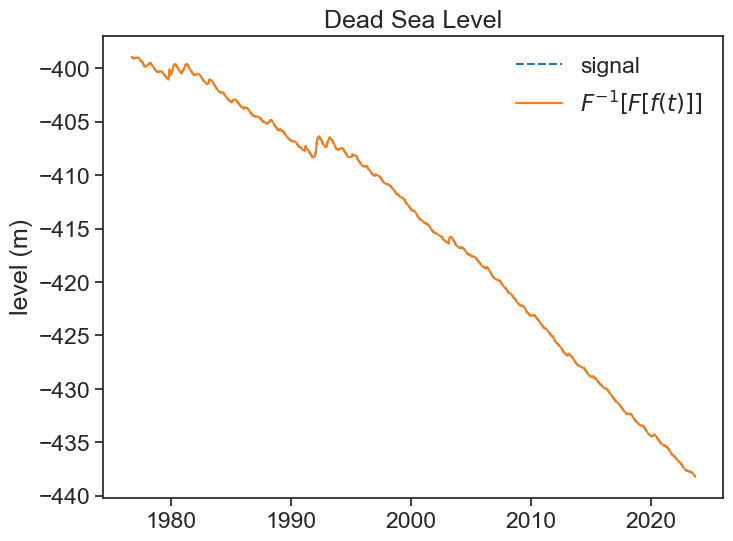

In [27]:
#| code-summary: "plot"
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(df['level'], ls="--", color="tab:blue", label="signal")
ax.plot(df['level'].index, reconstituted, color="tab:orange", label=r"$F^{-1}[F[f(t)]]$")
ax.legend(frameon=False)
ax.set(title="Dead Sea Level",
          ylabel="level (m)");

Now let's apply some smoothing, since we don't want a choppy derivative.

In [28]:
#| code-fold: false
fft = scipy.fft.fft(df['level'].values)
N = len(df['level'])
xi = scipy.fft.fftfreq(N)
cutoff_T = 3000.0 # days
cutoff_xi = 2.0 * np.pi / cutoff_T
mask = np.where(np.abs(xi) > cutoff_xi)
fft_filtered = fft.copy()
fft_filtered[mask] = 0.0
reconstituted = scipy.fft.ifft(fft_filtered).real

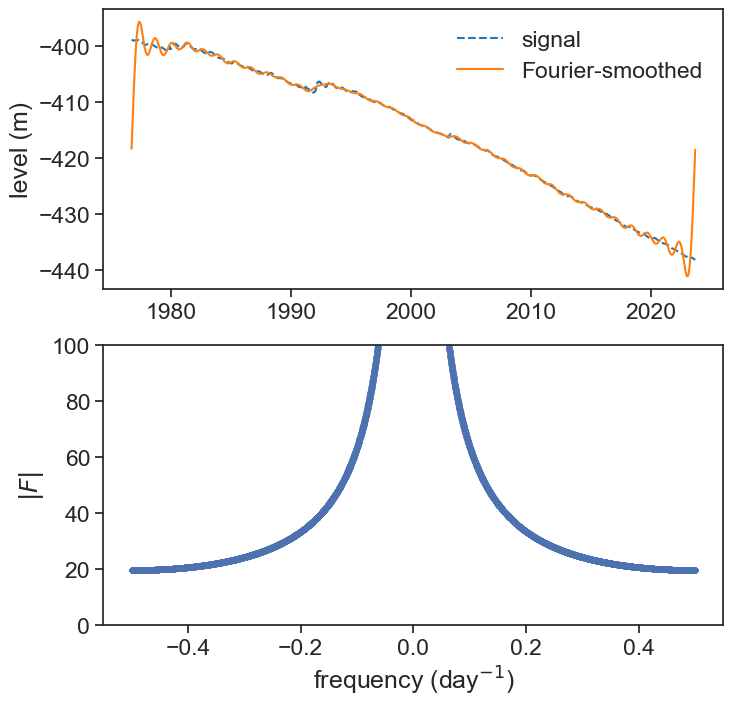

In [29]:
#| code-summary: "plot"
fig, ax = plt.subplots(2, 1, figsize=(8,8))
ax[0].plot(df['level'], ls="--", color="tab:blue", label="signal")
ax[0].plot(df['level'].index, reconstituted, color="tab:orange", label="Fourier-smoothed")
ax[0].legend(frameon=False)
ax[0].set(ylabel="level (m)")
ax[1].plot(xi, np.abs(fft), '.')
ax[1].set(ylim=[0,100],
          xlabel=r"frequency (day$^{-1}$)",
          ylabel=r"$|F|$");

There's a problem now! We eliminated high frequencies and now the smoothed signal is really bad at the edges.

The reason for this is that one assumption of the `fft` tool is that we have a **periodic signal**. Our signal is clearly not periodic, and when we treat it as it were periodic, we have a **very** broad power spectrum, that has really high values even for the highest frequencies. We need to solve this.

One trick to is to make our signal periodic by subtracting from it a straight line that joins the first and last points. See below.

In [30]:
#| code-summary: "define useful function"
def line_chord(p1, p2, t):
    """
    given two points p1 and p2, return equation for the line that connects between them
    """
    p1x, p1y = p1
    p2x, p2y = p2
    slope = (p1y-p2y) / (p1x-p2x)
    intercept = (p1x*p2y - p1y*p2x) / (p1x-p2x)
    return slope*t + intercept

In [31]:
#| code-fold: false
r = np.arange(len(df))
p1 = (r[0], df['level'][0])
p2 = (r[-1], df['level'][-1])
line = line_chord(p1, p2, r)
slope_mperday = (p2[1] - p1[1]) / (p2[0] - p1[0])
df['periodic_level'] = df['level'] - line

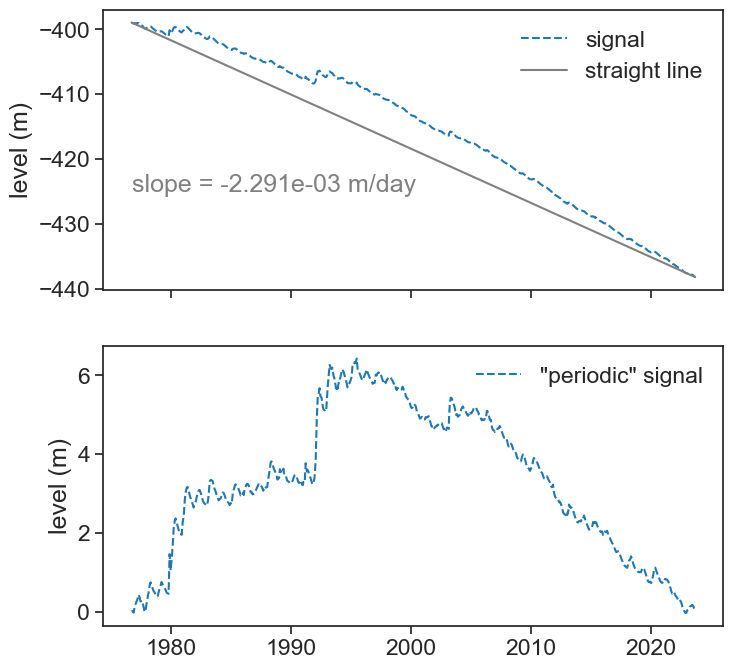

In [32]:
#| code-summary: "plot"
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)
ax[0].plot(df['level'], ls="--", color="tab:blue", label="signal")
ax[0].plot(df.index, line, color="gray", label="straight line")
ax[0].legend(frameon=False)
ax[0].set(ylabel="level (m)")
ax[0].text(df.index[0], -425, f"slope = {slope_mperday:.3e} m/day", color="gray")
ax[1].plot(df['periodic_level'], ls="--", color="tab:blue", label='"periodic" signal')
ax[1].legend(frameon=False)
ax[1].set(ylabel="level (m)");

We can now check that after removing the highest frequencies from the signal, the smoothed reconstitution doesn't suffer from weird boundary artifacts.

In [33]:
#| code-fold: false
fft = scipy.fft.fft(df['periodic_level'].values)
N = len(df)
xi = scipy.fft.fftfreq(N)
cutoff_T = 3000.0
cutoff_xi = 2.0 * np.pi / cutoff_T
mask = np.where(np.abs(xi) > cutoff_xi)
fft_filtered = fft.copy()
fft_filtered[mask] = 0.0
reconstituted = scipy.fft.ifft(fft_filtered).real

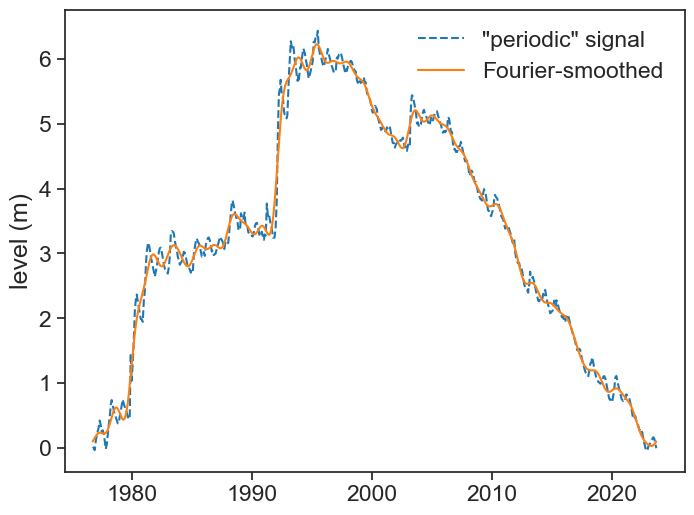

In [34]:
#| code-summary: "plot"
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharex=True)
ax.plot(df['periodic_level'], ls="--", color="tab:blue", label='"periodic" signal')
ax.plot(df.index, reconstituted, color="tab:orange", label="Fourier-smoothed")
ax.legend(frameon=False)
ax.set(ylabel="level (m)");

That looks great! We can finally calculate the derivative of the smoothed signal by using the nice property we saw at the top of this page.

In [35]:
#| code-fold: false
derivative = scipy.fft.ifft(2.0*np.pi*1j*xi*fft_filtered).real
derivative_correct = derivative + slope_mperday

We have to correct for the fact that we subtracted a straight line from our original signal:

$$
\begin{split}
\frac{d}{dt}\text{signal} &= \frac{d}{dt}\left[\text{``periodic'' signal + line}\right] \\
                          &= \frac{d}{dt}\left[\text{``periodic'' signal}\right] + \text{slope}
\end{split}
$$

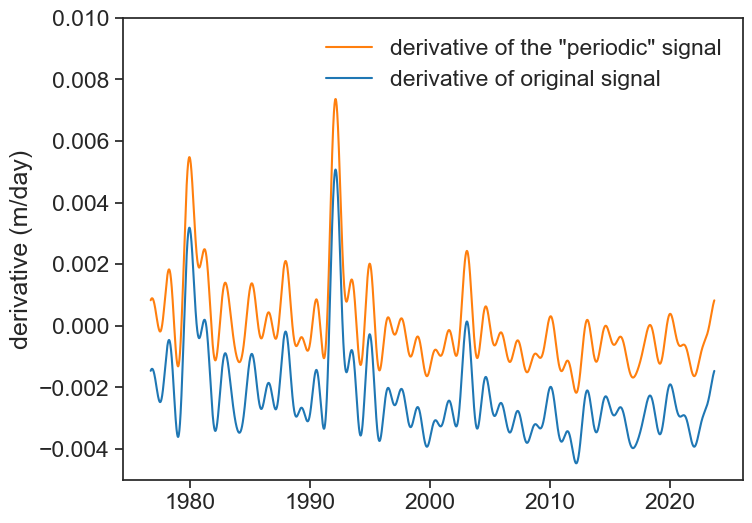

In [36]:
#| code-summary: "plot"
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(df['level'].index, derivative, color="tab:orange", label='derivative of the "periodic" signal')
ax.plot(df['level'].index, derivative_correct, color="tab:blue", label="derivative of original signal")
ax.legend(frameon=False)
ax.set(ylim=[-0.005, 0.010],
       ylabel="derivative (m/day)");

How does our solution compare to the previous method, the gradient?

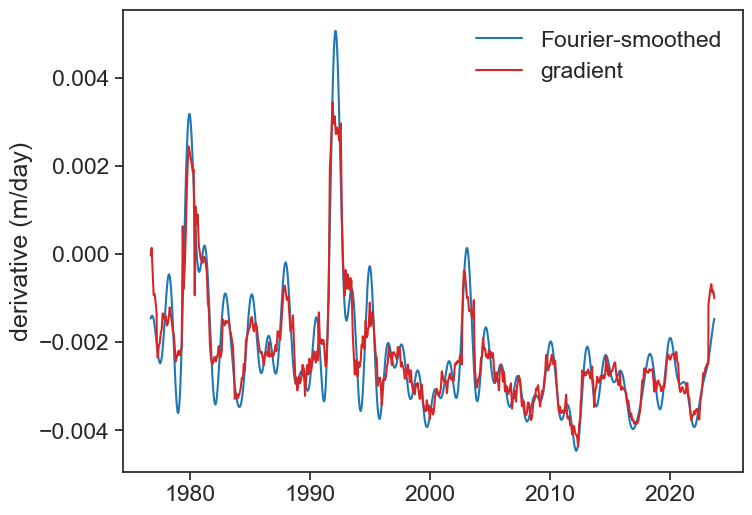

In [37]:
#| code-summary: "compare Fourier and gradient methods"
df['level_smooth_yr'] = df['level'].rolling('365D', center=True).mean()
df['grad_yr'] = np.gradient(df['level_smooth_yr'].values)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(df['level'].index, derivative_correct, color="tab:blue", label="Fourier-smoothed")
ax.plot(df['grad_yr'], color="tab:red", label="gradient")
ax.legend(frameon=False)
ax.set(ylabel="derivative (m/day)");